# Chapter 6. How do I build a model to predict a variable of interest?

### Documentation

* Hexbin plots: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hexbin.html




Prediction problems are ubiquitous in real world applications. For example:

- A real estate agent might want to predict the fair price of a home, using features about the home.
- A sports bettor might want to predict which team will win the game, using information about the teams.
- A historian might want to predict which historical figure wrote an anonymous document, using the words in the document.

In each case, we have **features**, such as square footage and number of bedrooms, that we want to use to predict a **label**, such as house price. We can formalize the problem mathematically as follows: let $X$ be the features and $y$ the label; a **predictive model** is a function $f$ that maps $X$ to $y$:

$$ f: X \mapsto y. $$

Now suppose we have a new house, with features $X^*$. A predictive model $f$ predicts the price of this house to be $f(X^*)$.

How do we come up a predictive model $f$ in the first place? One way is to learn it from existing data, or **training data**. The training data consists of features and the corresponding labels. For example, to build a model to predict the price of a home using the square footage (`Gr Liv Area`), we would need training data like the points shown in black below.

<img src="predictive_model.png" />

We could then learn a model, $f$, from this training data. For example, one possible predictive model is the red curve shown in the plot. This model was chosen to fit the points in the training data as closely as possible. If we wanted to predict the price of a 2700 square foot home using this model, we would simply evaluate $f(2700)$, which comes out to about 300,000. The key thing to note is that $f$ depends on the training data. If the training data changes, then so does $f$.

The field that studies how to learn predictive models from data is known as **machine learning**. There are many algorithms for learning predictive models from data, including _linear regression_ (which you may be familiar with from a statistics course), _decision trees_, and _neural networks_. In this chapter, we will focus on one machine learning algorithm called **k-nearest neighbors** that leverages the distance metrics that you learned about in the previous chapter.

Predictive models are classified into two types, depending on whether the label $y$ is categorical or quantitative. If the label is categorical, then the model is called a **classifier**. If the label is quantitative, then the model is called a **regressor**. Chapter 6  covers classification, while Chapter 5 covered regression.

# Chapter 6.1 K-Nearest Neighbors for Classification

_Classification models_ are used to predict labels that are categorical. In this section, we will train a machine learning model to predict the color of a wine (red or white) from its chemical properties. 

The training data for the red and white wines are stored in separate files (`/data301/data/winequality-red.csv` and `/data301/data/winequality-white.csv`). Let's read in the two datasets, add a column for the color ("red" or "white"), and combine them into one `DataFrame`.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.options.display.max_rows = 5

reds = pd.read_csv("../data/wines/reds.csv", sep=";")
whites = pd.read_csv("../data/wines/whites.csv", sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites], ignore_index=True)
wines

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
...             ...               ...          ...             ...        ...   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
...                   ...                   ...      ...   ...        ...   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  color  
0         9.4        5    red  
1         9.8        5    red  
...       ...      ...    ...  
6495     12.8        7  white  
6496     11.8        6  white  

[6497 rows x 13 columns]

Let's focus on just two features for now: volatile acidity and total sulfur dioxide. Let's plot the training data, using color to represent the class label.

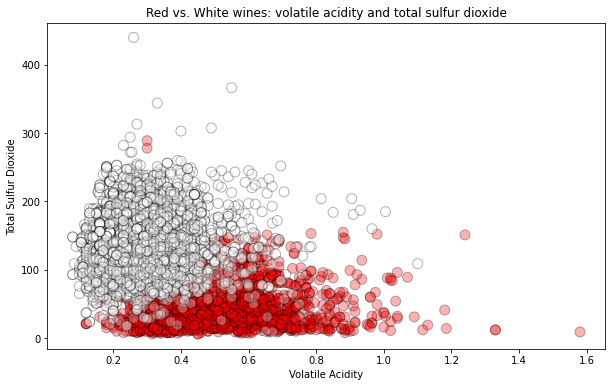

In [2]:
#colors = wines["color"].map({
#    "red": "darkred",
#    "white": "gold"
#})
plt.figure(figsize=(10,6))
plt.title("Red vs. White wines: volatile acidity and total sulfur dioxide")
plt.xlabel("Volatile Acidity")
plt.ylabel("Total Sulfur Dioxide")
plt.scatter(x=wines["volatile acidity"], y=wines["total sulfur dioxide"],s=100, alpha=0.3, c=wines["color"], edgecolors="black")

plt.show()

Now suppose that we have a new wine with volatile acidity .85 and total sulfur dioxide 120, represented by a black circle in the plot below. Is this likely a red wine or a white wine?


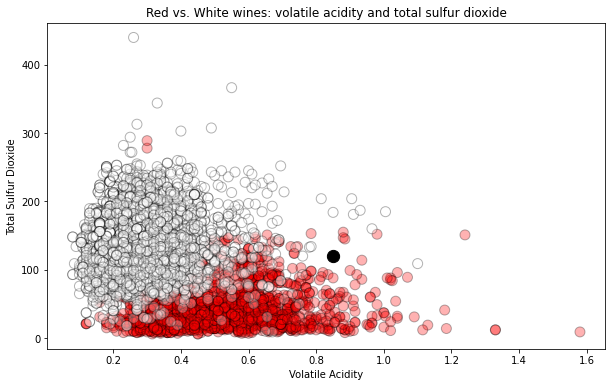

In [3]:

## Adding one data point to the set of red and white wine data points
#winesTmp = wines[["volatile acidity", "total sulfur dioxide"]]
#winesTmp = pd.concat([winesTmp, pd.DataFrame([(0.85, 120)], columns=["volatile acidity", "total sulfur dioxide"])], ignore_index=True)

## Add black color to the list of colors
#colorsTmp=pd.concat([colors, pd.Series(["black"])])

## make the query data point larger for better visibility
#sizes = np.full(len(winesTmp), 30)
#sizes[-1]= 130

## draw

#winesTmp.plot.scatter(x="volatile acidity", y="total sulfur dioxide", c=colorsTmp, s=sizes,
#                   alpha=.9, xlim=(0, 1.6), ylim=(0, 400));

plt.figure(figsize=(10,6))
plt.title("Red vs. White wines: volatile acidity and total sulfur dioxide")
plt.xlabel("Volatile Acidity")
plt.ylabel("Total Sulfur Dioxide")
plt.scatter(x=wines["volatile acidity"], y=wines["total sulfur dioxide"],s=100, alpha=0.3, c=wines["color"], edgecolors="black")
plt.scatter(x = np.array([.85]), y=np.array([120]), s=150, c="black")

plt.show()






<img src="classification.png" />

It is probably not hard to see that this wine is probably red, just by looking at the plot. But let's try to generalize this reasoning into a algorithm that will work when there are more than two features, where visualizing the data is not easy.

Your reasoning likely went something like this: most of the wines in the training data that were "close" to this wine were reds, so it makes sense to predict that this wine is also red. This is precisely the idea behind the $k$-nearest neighbors algorithm:

1. Calculate the distance between the new point and each point in the training data, using some distance metric on the features.
2. Determine the $k$ closest points. Of these $k$ closest points, count up how many of each class label there are.
3. The predicted class of the new point is whichever class was most common among the $k$ closest points.

Let's implement $9$-nearest neighbors for the wine above. First, we extract the training data and standardize the features:

In [4]:
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

X_train_stand = (X_train - X_train.mean()) / X_train.std()

Then, we create a `Series` for the new wine, making sure to standardize it in the exact same way:

In [5]:
x_new = pd.DataFrame([(0.85, 120)], columns=["volatile acidity", "total sulfur dioxide"])
#x_new["volatile acidity"] = .85
#x_new["total sulfur dioxide"] = 120

x_new_stand = (x_new - X_train.mean()) / X_train.std()

x_new_stand

volatile acidity  total sulfur dioxide
0          3.099763              0.075288

In [7]:
## NumPy arrays broadcast example
a = np.array([[1,2],[3,4],[5,6]])
b = np.array([[2,2]])

a,b, a-b

(array([[1, 2],
        [3, 4],
        [5, 6]]),
 array([[2, 2]]),
 array([[-1,  0],
        [ 1,  2],
        [ 3,  4]]))

In [8]:
## This does not broadcast:
## X_train_stand - x_new_stand  

## because of this, we need to convert our data frames into a NumPy arrays. NumPy arrays broadcast properly

np.array(X_train_stand) - np.array(x_new_stand)

array([[-0.91109823, -1.52153536],
       [ 0.18221965, -0.93769039],
       [-0.54665894, -1.16768992],
       ...,
       [-3.7051328 , -0.15923044],
       [-3.40143339, -0.17692272],
       [-3.88735244, -0.38922997]])

Now we calculate the (Euclidean) distance between this new wine and each wine in the training data, and sort the distances from smallest to largest.

In [9]:
## notice the conversions. To get broadcasting right we convert to numPy arrays
## to enable further sorting by the index, we convert the resulting numPy array into a Series
## the order of values will be preserved, so the index of the dists Series is the same as the index of the X_train_stand data frame

dists = pd.Series(np.sqrt(((np.array(X_train_stand) - np.array(x_new_stand)) ** 2).sum(axis=1)))
dists_sorted = dists.sort_values()
dists_sorted

782     0.462062
6391    0.466075
          ...   
3726    5.067728
6344    6.700407
Length: 6497, dtype: float64

The first 9 entries of this sorted list will be the 9 nearest neighbors. Let's get their index.

In [10]:
inds_nearest = dists_sorted.index[:9]
inds_nearest

Int64Index([782, 6391, 889, 4696, 198, 637, 636, 46, 6414], dtype='int64')

Now we can look up these indices in the original data.

In [11]:
wines.loc[inds_nearest]

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
782             9.0             0.820         0.05             2.4      0.081   
6391            4.7             0.785         0.00             3.4      0.036   
...             ...               ...          ...             ...        ...   
46              7.7             0.935         0.43             2.2      0.114   
6414            6.2             0.760         0.01             3.2      0.041   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
782                  26.0                  96.0  0.99814  3.36       0.53   
6391                 23.0                 134.0  0.98981  3.53       0.92   
...                   ...                   ...      ...   ...        ...   
46                   22.0                 114.0  0.99700  3.25       0.73   
6414                 18.0                 120.0  0.99026  3.20       0.94   

      alcohol  quality  color  
782      10.0        5    red  
6391     13.8        6  white  
...       ...      ...    ...  
46        9.2        5    red  
6414     13.7        7  white  

[9 rows x 13 columns]

As a sanity check, notice that these wines are all similar to the new wine in terms of volatile acidity and total sulfur dioxide. To make a prediction for this new wine, we need to count up how many reds and whites there are among these 9-nearest neighbors.

In [12]:
list(wines.loc[inds_nearest]["color"])

['red', 'white', 'red', 'white', 'red', 'red', 'red', 'red', 'white']

In [13]:
wines.loc[inds_nearest, "color"].value_counts()

red      6
white    3
Name: color, dtype: int64

There were more reds than whites, so this 9-nearest neighbors model predicts that the wine is red.

As a measure of confidence in a prediction, classification models typically report the predicted _probability_ of each label, instead of just the predicted label. The predicted probability of a class in a $k$-nearest neighbors model is simply the proportion of the $k$ neighbors that are in that class. In the above example, instead of simply predicting that the wine is red, we could have instead said that the wine has a $6/9 = .667$ predicted probability of being red.

## The K-Nearest Neighbors Classification Function

We defined a predictive model as a function $f: X \mapsto y$. What does $f$ look like for a $k$-nearest neighbors classifier? To specify $f$, we have to specify the predicted class for every possible combination of features $X$. When there are only two features $X_1$ and $X_2$, as in the example above, we can use a heat map to represent the predicted class for every possible value of $(X_1, X_2)$.

To be concrete, suppose we are predicting the color of a wine from just its volatile acidity and total sulfur dioxide. We have already extracted the training data (`X_train`, `y_train`) above. We need to create a grid of new $X$ values at which to evaluate the predictive model. The code below creates a new `DataFrame` containing a grid of values of volatile acidity and total sulfur dioxide.

In [14]:
wines["volatile acidity"].min(), wines["volatile acidity"].max()

(0.08, 1.58)

In [15]:
wines["total sulfur dioxide"].min(), wines["total sulfur dioxide"].max()

(6.0, 440.0)

In [16]:
volatile_acidity = []
total_sulfur_dioxide = []
for x1 in np.arange(0, 1.7, .05):
    for x2 in np.arange(0, 450,5):
        volatile_acidity.append(x1)
        total_sulfur_dioxide.append(x2)

X_new = pd.DataFrame()
X_new["volatile acidity"] = volatile_acidity
X_new["total sulfur dioxide"] = total_sulfur_dioxide

X_new

volatile acidity  total sulfur dioxide
0                 0.00                     0
1                 0.00                     5
...                ...                   ...
3058              1.65                   440
3059              1.65                   445

[3060 rows x 2 columns]

Next, we will define a function `k_nearest_neighbor_class` that implements the $k$-nearest neighbor algorithm above: given a new (standardized) observation, it returns the most common class label among the 9 nearest neighbors.

In [17]:
def k_nearest_neighbor_class(x_new_stand):
    """Given a new observation, returns the k-nearest neighbors prediction
    """
    dists = ((x_new_stand - X_train_stand) ** 2).sum(axis=1)
    inds_sorted = dists.sort_values().index[:9]
    return y_train.loc[inds_sorted].value_counts().idxmax()

We actually have 3060 new observations in `X_new`. We'll first standardize this data in the same way that we standardized the training data and then apply the function above to each of the standardized observations.

In [18]:
X_new_stand = (X_new - X_train.mean()) / X_train.std()
predictions = X_new_stand.apply(k_nearest_neighbor_class, axis=1)
predictions

0         red
1         red
        ...  
3058    white
3059    white
Length: 3060, dtype: object

To plot these predictions, we'll create a new `DataFrame` that stores both `X_new` and the corresponding predictions. Then, we can make a heatmap of this data using the `.plot.hexbin()` method. This method requires that the labels be converted to a quantitative scale, so we encode "red" as 1 and "yellow" as 0 and use a colormap that goes from yellow to red. (A list of all of the available colormaps can be found [here](https://matplotlib.org/examples/color/colormaps_reference.html).)

<AxesSubplot:xlabel='volatile acidity', ylabel='total sulfur dioxide'>

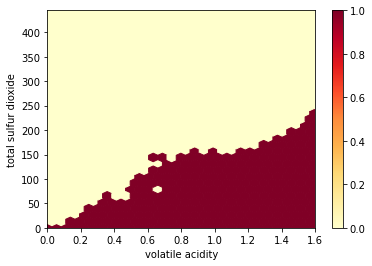

In [20]:
data_new = X_new.copy()
data_new["predictions"] = 1. * (predictions == "red")

data_new.plot.hexbin(x="volatile acidity", y="total sulfur dioxide",
                     C="predictions", cmap="YlOrRd",
                     reduce_C_function=min,
                     xlim=(0, 1.6), ylim=(0, 445), gridsize=30,
                     sharex=False)
# sharex=False is a workaround for a Pandas bug
# (https://github.com/pandas-dev/pandas/issues/10678)

# Exercises

**Exercise 1.** In the above example, we built a 9-nearest neighbors model to predict the color of a wine from just its volatile acidity and total sulfur dioxide. Use the model above to predict the color of the wine below.

Now, build a 9-nearest neighbors model using all of the features in the data set. Use this new model to predict the color of the wine below. Does the predicted label change? Do the predicted probabilities of the labels change?

In [ ]:
# TYPE YOUR CODE HERE
x_new = pd.Series()
x_new["fixed acidity"] = 11.2
x_new["volatile acidity"] = 0.28
x_new["citric acid"] = 0.26
x_new["residual sugar"] = 1.9
x_new["chlorides"] = 0.075
x_new["free sulfur dioxide"] = 17
x_new["total sulfur dioxide"] = 60
x_new["density"] = 0.998
x_new["pH"] = 3.16
x_new["sulphates"] = 0.58
x_new["alcohol"] = 9.8
x_new["quality"] = 6

**Exercise 2.** Build a 5-nearest neighbors model to predict whether or not a passenger on a Titanic would survive, using their age, sex, and class as features. Use the Titanic data set (`../data/titanic.csv`) as your training data. Then, using your model, predict whether a 20-year old female in first-class would survive. What about a 20-year old female in third-class?

In [ ]:
# TYPE YOUR CODE HERE